**Proyek Machine Learning untuk Prediksi Biaya Asuransi Kesehatan**

**Latar Belakang**

Industri asuransi kesehatan menghadapi tantangan dalam menentukan premi yang adil bagi pelanggan sambil tetap menjaga profitabilitas perusahaan. Biaya klaim asuransi kesehatan dipengaruhi oleh berbagai faktor seperti usia, indeks massa tubuh (BMI), jumlah tanggungan, dan kebiasaan merokok. Dengan memahami faktor-faktor yang mempengaruhi biaya asuransi, perusahaan asuransi dapat:

1. Menetapkan premi yang lebih akurat dan adil berdasarkan profil risiko individu
2. Mengidentifikasi kelompok berisiko tinggi yang memerlukan intervensi preventif
3. Mengoptimalkan strategi bisnis untuk meningkatkan profitabilitas dan keberlanjutan jangka panjang

Selain itu, prediksi biaya yang akurat juga bermanfaat bagi konsumen untuk merencanakan keuangan pribadi mereka dengan lebih baik.

**Permasalahan**

Bagaimana cara memprediksi biaya klaim asuransi kesehatan individu berdasarkan karakteristik demografis dan kesehatan mereka dengan akurasi yang dapat diandalkan?

**Pendekatan**

Proyek ini menggunakan pendekatan regresi karena variabel target (biaya asuransi) bersifat kontinu. Beberapa algoritma regresi akan diuji dan dibandingkan untuk menemukan model dengan performa terbaik.


**Persiapan Project**

In [1]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

**Data Understanding**

**Deskripsi Dataset**

Dataset yang digunakan berisi informasi tentang pemegang polis asuransi kesehatan. Dataset ini memiliki 1338 baris dan 7 kolom

In [2]:
# Load dataset
df = pd.read_csv('/content/insurance.csv')

# Melihat beberapa data pertama
print("Sample data:")
df.head()

Sample data:


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Informasi dataset
print("\nInformasi dataset:")
df.info()

# Statistik deskriptif
print("\nStatistik deskriptif:")
df.describe()


Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Statistik deskriptif:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


**Variabel-variabel pada Dataset**

1. age: Usia pemegang polis (numerik)
2. sex: Jenis kelamin pemegang polis (kategori: female/male)
3. bmi: Body Mass Index, indikator massa tubuh relatif terhadap tinggi dan berat badan (numerik)
4. children: Jumlah anak/tanggungan yang tercakup dalam asuransi (numerik)
5. smoker: Status merokok (kategori: yes/no)
6. region: Wilayah tempat tinggal di AS (kategori: northeast, northwest, southeast, southwest)
67. charges: Biaya medis yang dibebankan oleh asuransi kesehatan (numerik) - variabel target

**Eksplorasi Data Analysis (EDA)**

**Distribusi Variabel Target (Charges)**

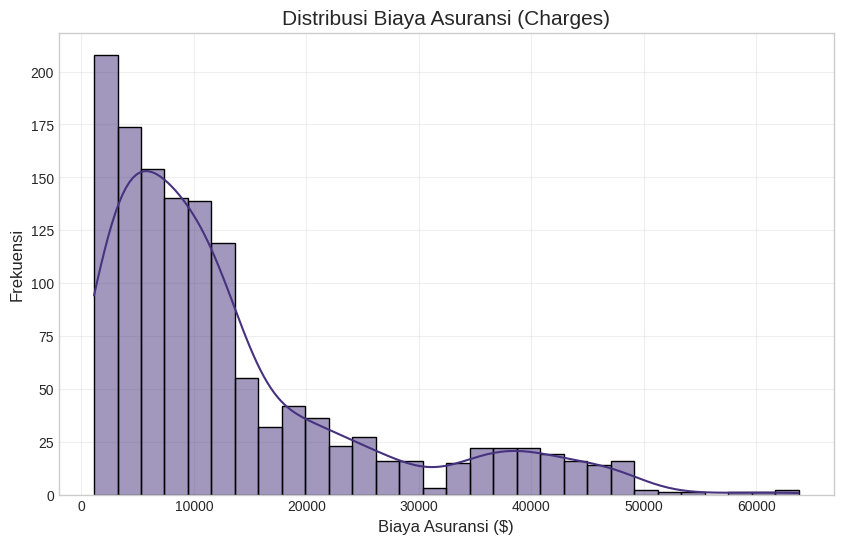

Skewness: 1.5158796580240388


In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(df['charges'], kde=True)
plt.title('Distribusi Biaya Asuransi (Charges)', fontsize=15)
plt.xlabel('Biaya Asuransi ($)', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Skewness: {df['charges'].skew()}")


Distribusi biaya asuransi terlihat miring ke kanan (positively skewed), menunjukkan bahwa sebagian besar pemegang polis memiliki biaya yang relatif rendah, sementara sebagian kecil memiliki biaya yang sangat tinggi.

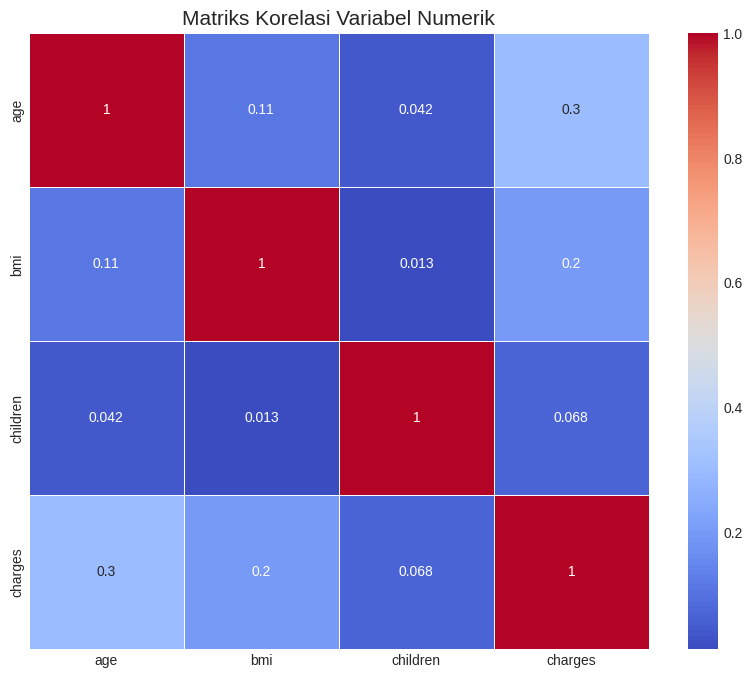

<Figure size 1200x1000 with 0 Axes>

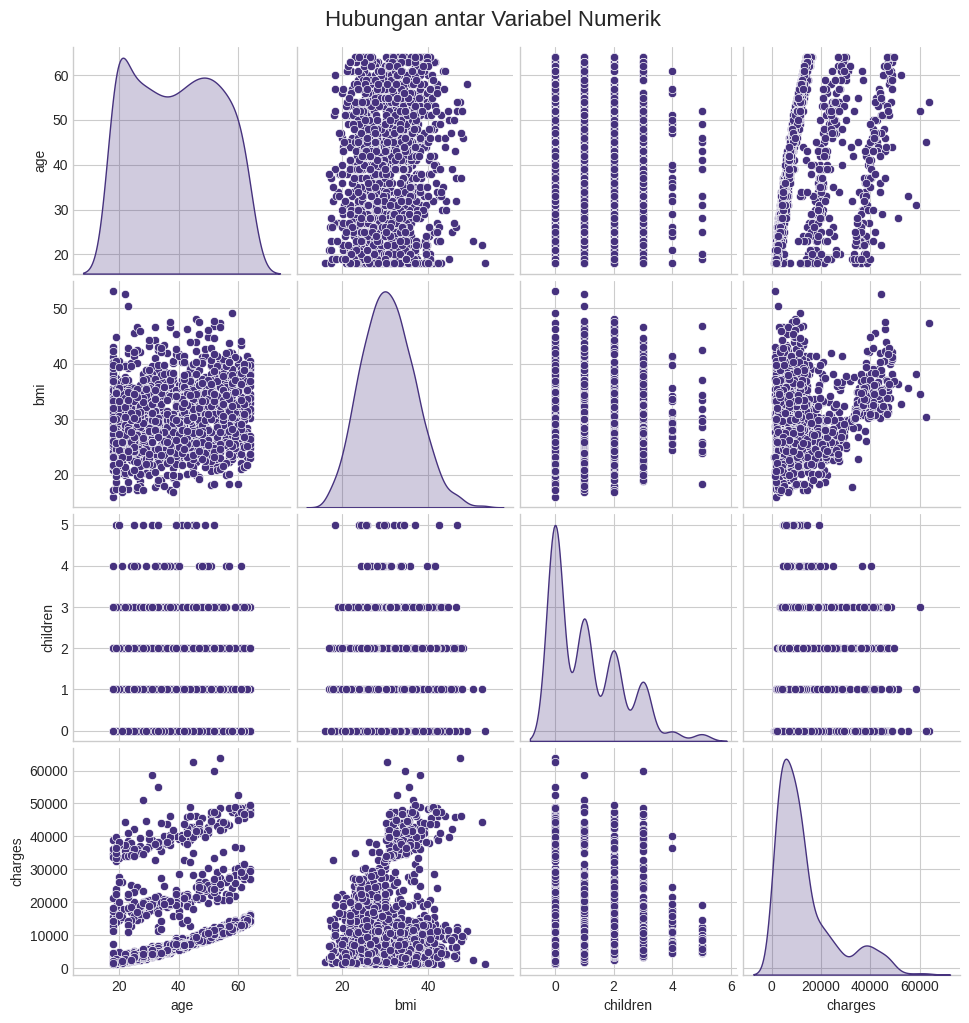

In [6]:
# Matrik korelasi untuk variabel numerik
plt.figure(figsize=(10, 8))
correlation = df[['age', 'bmi', 'children', 'charges']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriks Korelasi Variabel Numerik', fontsize=15)
plt.show()
# Scatterplot matriks
plt.figure(figsize=(12, 10))
sns.pairplot(df[['age', 'bmi', 'children', 'charges']], diag_kind='kde')
plt.suptitle('Hubungan antar Variabel Numerik', y=1.02, fontsize=16)
plt.show()

**Analisis Faktor Kategorikal**

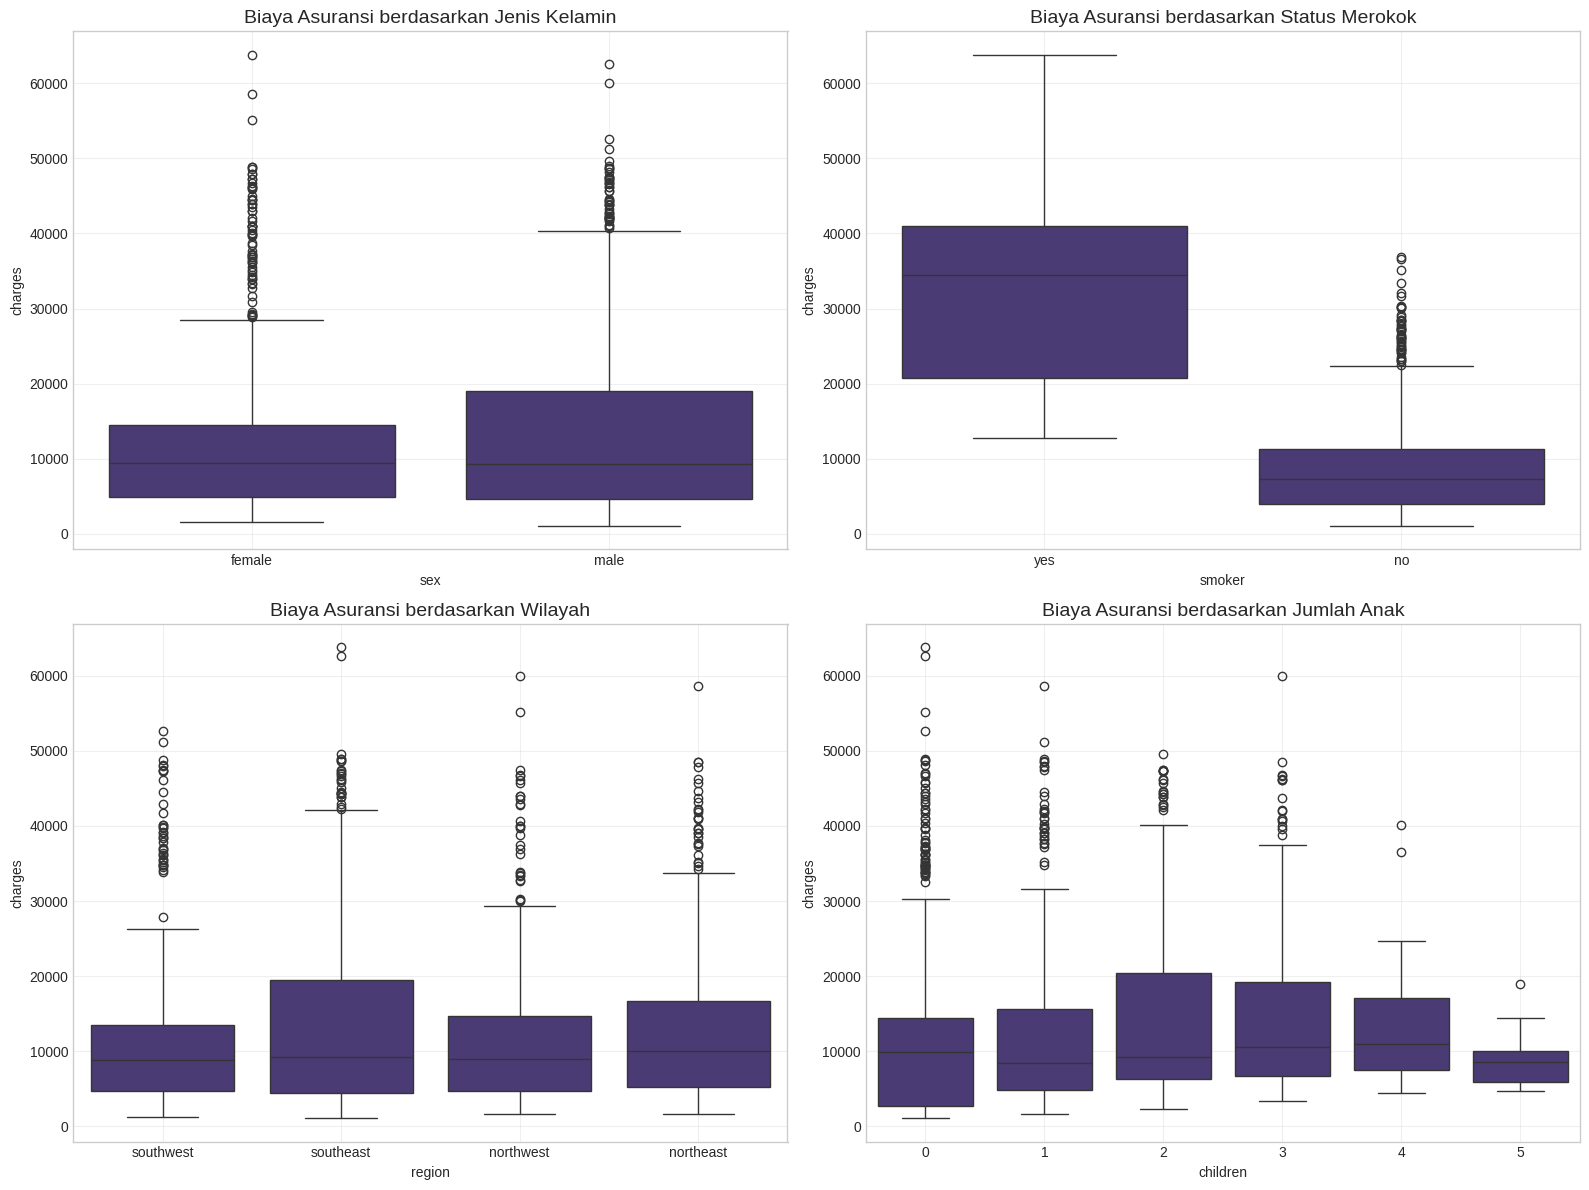

In [7]:
plt.figure(figsize=(16, 12))

# Jenis kelamin vs biaya
plt.subplot(2, 2, 1)
sns.boxplot(x='sex', y='charges', data=df)
plt.title('Biaya Asuransi berdasarkan Jenis Kelamin', fontsize=14)
plt.grid(True, alpha=0.3)

# Status merokok vs biaya
plt.subplot(2, 2, 2)
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Biaya Asuransi berdasarkan Status Merokok', fontsize=14)
plt.grid(True, alpha=0.3)

# Wilayah vs biaya
plt.subplot(2, 2, 3)
sns.boxplot(x='region', y='charges', data=df)
plt.title('Biaya Asuransi berdasarkan Wilayah', fontsize=14)
plt.grid(True, alpha=0.3)

# Jumlah anak vs biaya
plt.subplot(2, 2, 4)
sns.boxplot(x='children', y='charges', data=df)
plt.title('Biaya Asuransi berdasarkan Jumlah Anak', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

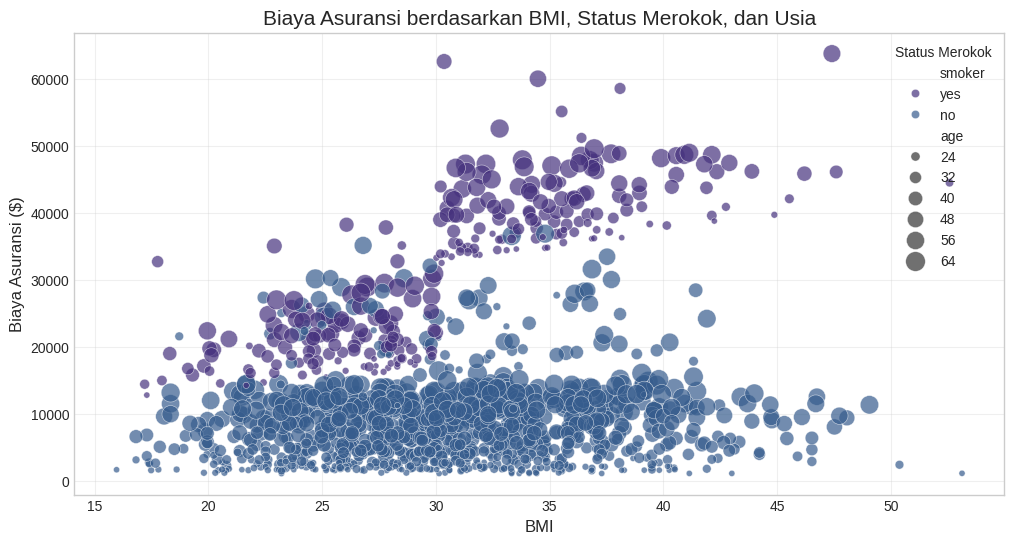

In [8]:
# Interaksi antara status merokok dan BMI
plt.figure(figsize=(12, 6))
sns.scatterplot(x='bmi', y='charges', hue='smoker', size='age', sizes=(20, 200), data=df, alpha=0.7)
plt.title('Biaya Asuransi berdasarkan BMI, Status Merokok, dan Usia', fontsize=15)
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Biaya Asuransi ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Status Merokok', fontsize=10)
plt.show()

**Insight dari EDA**

1. Status Merokok: Faktor yang sangat berpengaruh terhadap biaya asuransi. Perokok memiliki biaya asuransi jauh lebih tinggi dibandingkan non-perokok.
2. Usia: Terdapat korelasi positif dengan biaya asuransi. Semakin tua seseorang, biaya asuransi cenderung semakin tinggi.
3. BMI: BMI juga memiliki korelasi positif dengan biaya asuransi, tetapi efeknya lebih kuat pada kelompok perokok.
4. Jumlah Anak: Sedikit berpengaruh terhadap biaya asuransi.
5. Distribusi Biaya: Terdapat skewness positif, menunjukkan bahwa sebagian kecil pelanggan memiliki biaya sangat tinggi.
6. Region: Tidak menunjukkan perbedaan yang signifikan dalam biaya asuransi.

**Data Preparation**

**Penanganan Data Kategorikal**

In [10]:
# Cek nilai unik untuk kolom kategorikal
print("Nilai unik di kolom sex:", df['sex'].unique())
print("Nilai unik di kolom smoker:", df['smoker'].unique())
print("Nilai unik di kolom region:", df['region'].unique())

# Cek missing values
print("\nJumlah missing values per kolom:")
df.isnull().sum()

Nilai unik di kolom sex: ['female' 'male']
Nilai unik di kolom smoker: ['yes' 'no']
Nilai unik di kolom region: ['southwest' 'southeast' 'northwest' 'northeast']

Jumlah missing values per kolom:


,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [11]:
# Tidak ada missing values, lanjut ke encoding

# Definisikan kolom kategorikal dan numerik
categorical_features = ['sex', 'smoker', 'region']
numeric_features = ['age', 'bmi', 'children']

# Buat preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Cek data outlier menggunakan metode IQR untuk variable target
Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1

print("\nAnalisis Outlier pada Biaya Asuransi:")
print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Batas Bawah: {Q1 - 1.5 * IQR}")
print(f"Batas Atas: {Q3 + 1.5 * IQR}")
print(f"Jumlah outlier: {len(df[(df['charges'] < Q1 - 1.5 * IQR) | (df['charges'] > Q3 + 1.5 * IQR)])}")


Analisis Outlier pada Biaya Asuransi:
Q1: 4740.28715
Q3: 16639.912515
IQR: 11899.625365
Batas Bawah: -13109.1508975
Batas Atas: 34489.350562499996
Jumlah outlier: 139


**Transformasi Fitur Tambahan**

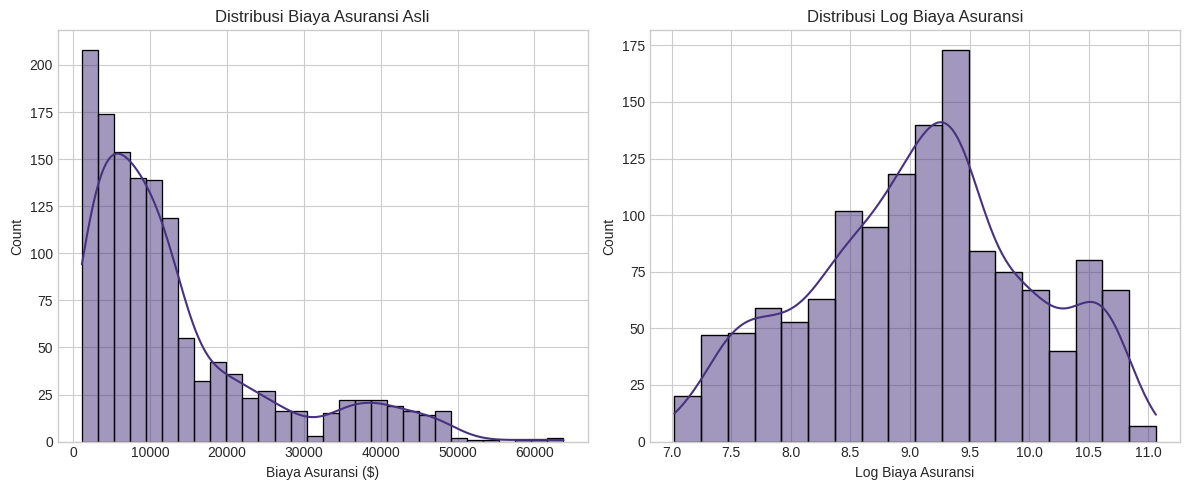

In [12]:
# Menambahkan fitur interaksi antara BMI dan status merokok
df['bmi_smoker'] = df['bmi'] * (df['smoker'] == 'yes').astype(int)

# Menambahkan fitur interaksi antara usia dan status merokok
df['age_smoker'] = df['age'] * (df['smoker'] == 'yes').astype(int)

# Karena distribusi charges skewed, kita coba log transform
df['log_charges'] = np.log(df['charges'])

# Visualisasi distribusi setelah log transform
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['charges'], kde=True)
plt.title('Distribusi Biaya Asuransi Asli', fontsize=12)
plt.xlabel('Biaya Asuransi ($)')

plt.subplot(1, 2, 2)
sns.histplot(df['log_charges'], kde=True)
plt.title('Distribusi Log Biaya Asuransi', fontsize=12)
plt.xlabel('Log Biaya Asuransi')

plt.tight_layout()
plt.show()

**Train-Test Split**

In [13]:
# Pilih fitur dan target
X = df[['age', 'bmi', 'children', 'sex', 'smoker', 'region', 'bmi_smoker', 'age_smoker']]
y = df['charges']  # Menggunakan charges asli, bukan log transform untuk kemudahan interpretasi

# Pembagian data training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Ukuran data training: {X_train.shape}")
print(f"Ukuran data testing: {X_test.shape}")

Ukuran data training: (1070, 8)
Ukuran data testing: (268, 8)


**Modeling**

Pada tahap ini, kita akan membandingkan beberapa algoritma regresi:

1. Linear Regression
2. Ridge Regression (Regularized linear regression)
3. Random Forest Regression
4. Gradient Boosting Regression

**Fungsi Evaluasi Model**

In [17]:
def evaluate_model(name, model, X_test, y_test):
    """Evaluasi model dan tampilkan metrik performa"""
    y_pred = model.predict(X_test)

    # Hitung metrik
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{name} Performance:")
    print(f"MAE: ${mae:.2f}")
    print(f"MSE: ${mse:.2f}")
    print(f"RMSE: ${rmse:.2f}")
    print(f"R² Score: {r2:.4f}")

    # Visualisasi hasil prediksi vs aktual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Biaya Aktual ($)', fontsize=12)
    plt.ylabel('Biaya Prediksi ($)', fontsize=12)
    plt.title(f'Aktual vs Prediksi - {name}', fontsize=15)
    plt.grid(True, alpha=0.3)
    plt.show()

    return {'name': name, 'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}

**Model 1: Linear Regression**


Linear Regression Performance:
MAE: $4181.19
MSE: $33596915.85
RMSE: $5796.28
R² Score: 0.7836


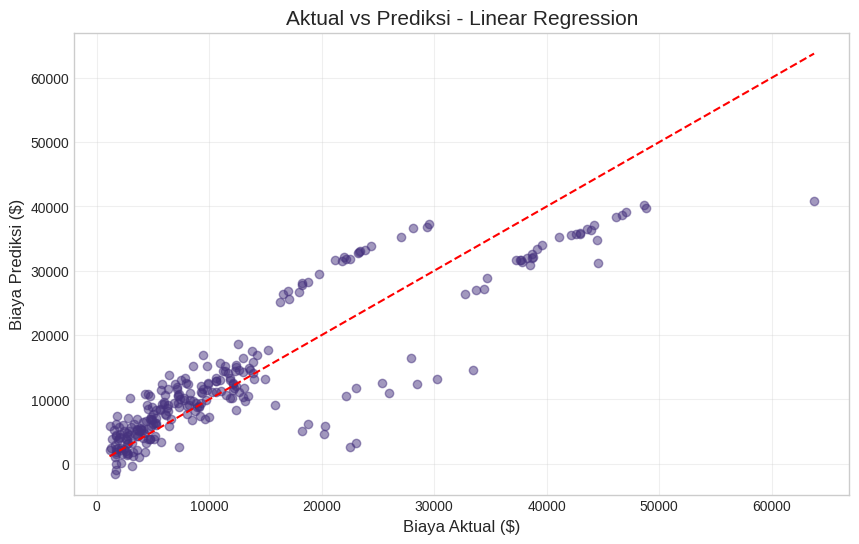

In [18]:
# Buat pipeline untuk Linear Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Training model
lr_pipeline.fit(X_train, y_train)

# Evaluasi model
lr_results = evaluate_model("Linear Regression", lr_pipeline, X_test, y_test)

**Model 2: Ridge Regression**

Ridge best alpha: 1.0

Ridge Regression Performance:
MAE: $4193.20
MSE: $33645393.49
RMSE: $5800.46
R² Score: 0.7833


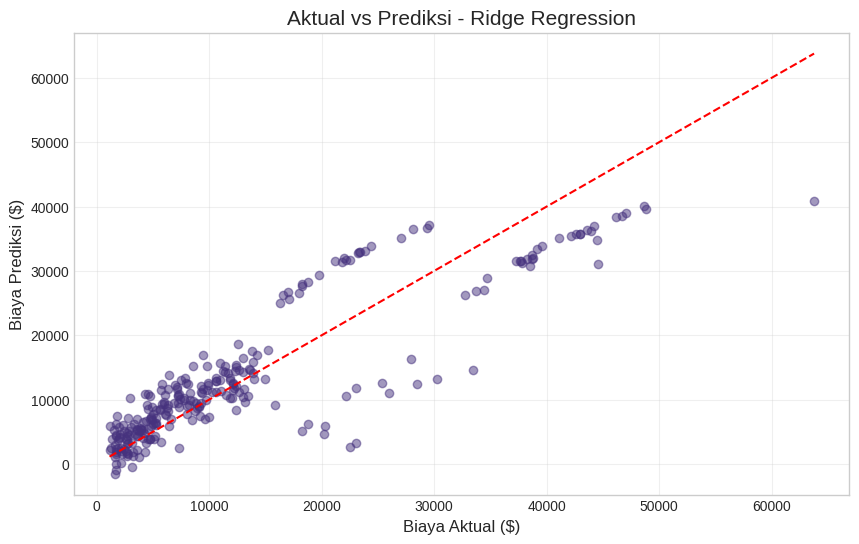

In [19]:
# Ridge Regression dengan cross-validation untuk memilih parameter alpha terbaik
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Parameter grid untuk Ridge
ridge_params = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

# Grid search untuk menemukan parameter terbaik
ridge_cv = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

print(f"Ridge best alpha: {ridge_cv.best_params_['regressor__alpha']}")

# Evaluasi model Ridge terbaik
ridge_results = evaluate_model("Ridge Regression", ridge_cv.best_estimator_, X_test, y_test)

**Model 3: Random Forest Regression**

Random Forest best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}

Random Forest Regression Performance:
MAE: $2524.40
MSE: $20457272.96
RMSE: $4522.97
R² Score: 0.8682


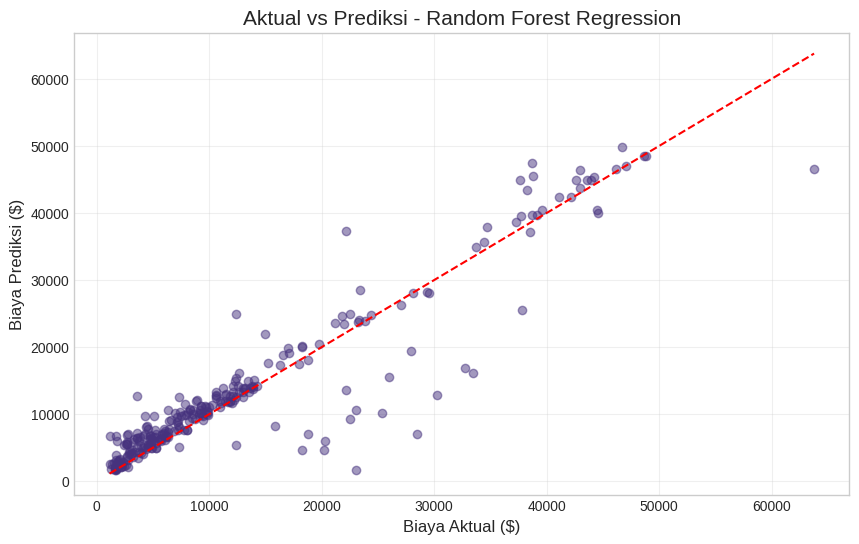

In [20]:
# Random Forest Regression
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Parameter grid untuk Random Forest
rf_params = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

# Grid search untuk menemukan parameter terbaik
rf_cv = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train, y_train)

print(f"Random Forest best parameters: {rf_cv.best_params_}")

# Evaluasi model Random Forest terbaik
rf_results = evaluate_model("Random Forest Regression", rf_cv.best_estimator_, X_test, y_test)

**Model 4: Gradient Boosting Regression**

Gradient Boosting best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}

Gradient Boosting Regression Performance:
MAE: $2464.90
MSE: $18766950.15
RMSE: $4332.08
R² Score: 0.8791


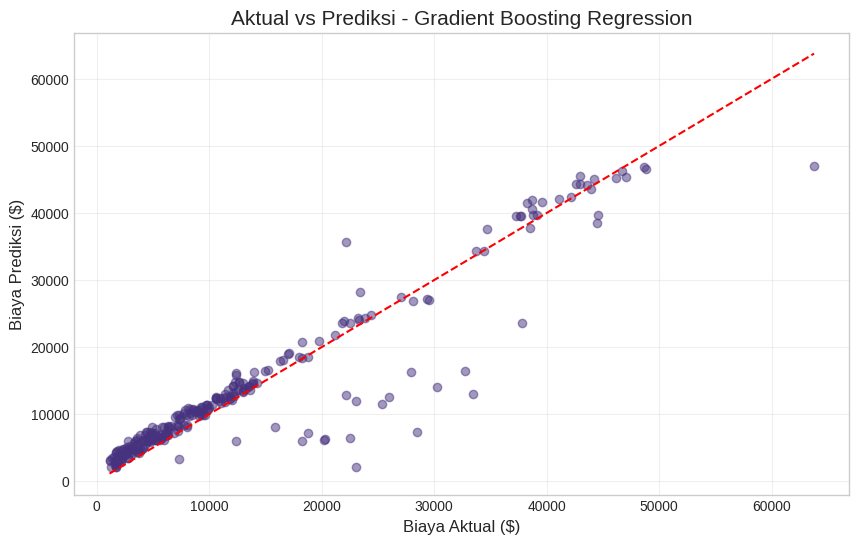

In [21]:
# Gradient Boosting Regression
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Parameter grid untuk Gradient Boosting
gb_params = {
    'regressor__n_estimators': [50, 100],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 5]
}

# Grid search untuk menemukan parameter terbaik
gb_cv = GridSearchCV(gb_pipeline, gb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gb_cv.fit(X_train, y_train)

print(f"Gradient Boosting best parameters: {gb_cv.best_params_}")

# Evaluasi model Gradient Boosting terbaik
gb_results = evaluate_model("Gradient Boosting Regression", gb_cv.best_estimator_, X_test, y_test)

**Perbandingan Model**

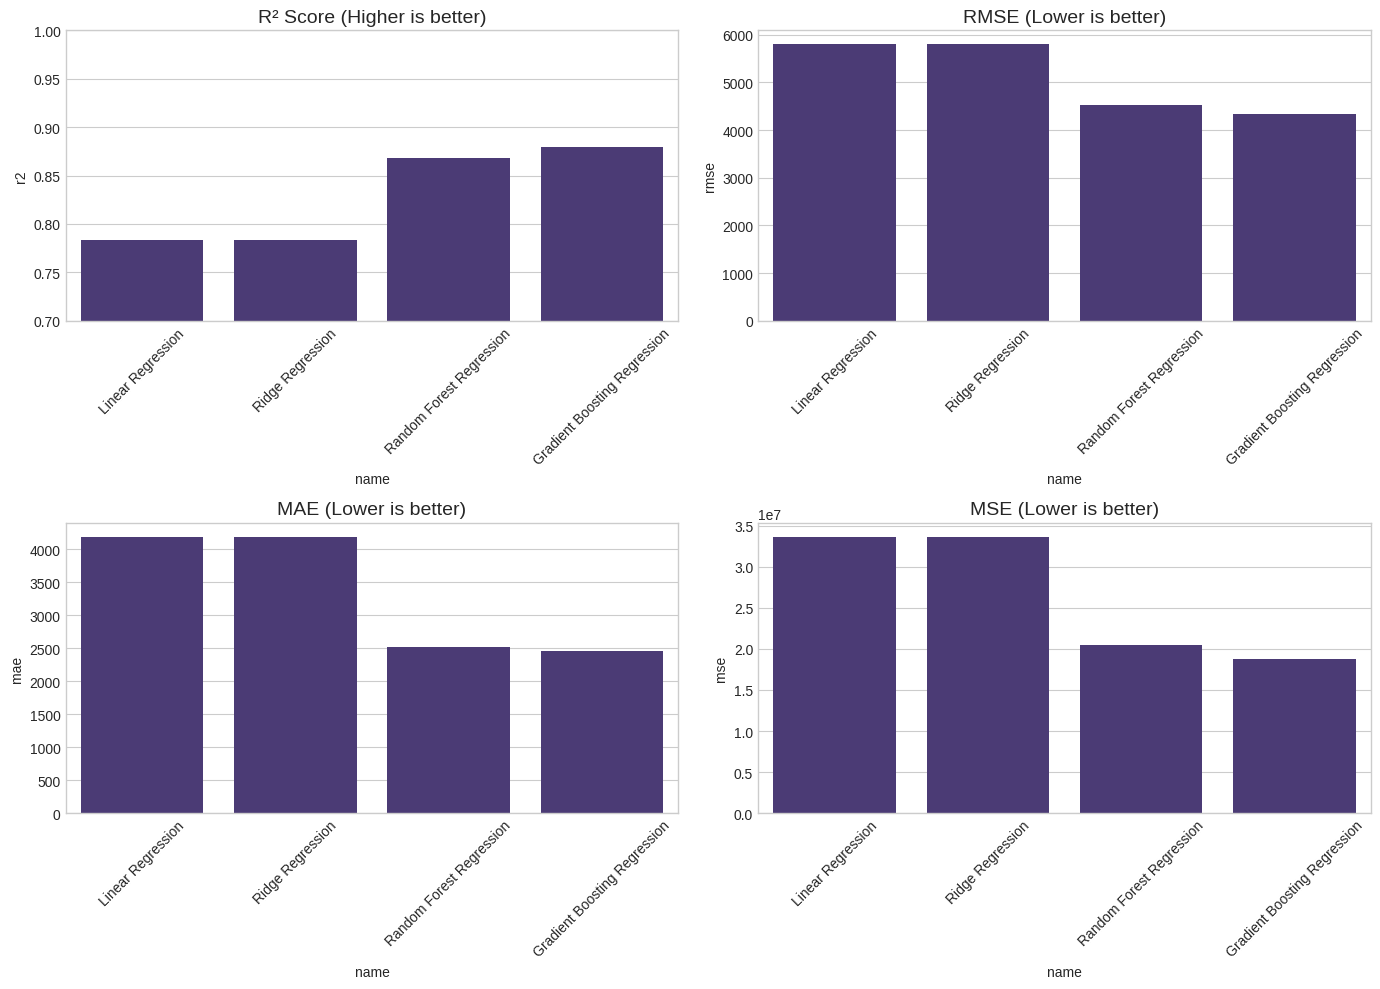


Perbandingan Model:
                           name        r2         rmse          mae
3  Gradient Boosting Regression  0.879117  4332.083812  2464.898853
2      Random Forest Regression  0.868229  4522.971696  2524.397531
0             Linear Regression  0.783593  5796.284659  4181.194474
1              Ridge Regression  0.783281  5800.464938  4193.195353


In [22]:
# Kumpulkan hasil dari semua model
results = [lr_results, ridge_results, rf_results, gb_results]
results_df = pd.DataFrame(results)

# Bandingkan metrik performa
plt.figure(figsize=(14, 10))

# Plot R²
plt.subplot(2, 2, 1)
sns.barplot(x='name', y='r2', data=results_df)
plt.title('R² Score (Higher is better)', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)  # Adjust as needed

# Plot RMSE
plt.subplot(2, 2, 2)
sns.barplot(x='name', y='rmse', data=results_df)
plt.title('RMSE (Lower is better)', fontsize=14)
plt.xticks(rotation=45)

# Plot MAE
plt.subplot(2, 2, 3)
sns.barplot(x='name', y='mae', data=results_df)
plt.title('MAE (Lower is better)', fontsize=14)
plt.xticks(rotation=45)

# Plot MSE
plt.subplot(2, 2, 4)
sns.barplot(x='name', y='mse', data=results_df)
plt.title('MSE (Lower is better)', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Tabel perbandingan
print("\nPerbandingan Model:")
print(results_df[['name', 'r2', 'rmse', 'mae']].sort_values(by='r2', ascending=False))

**Analisis Feature Importance**

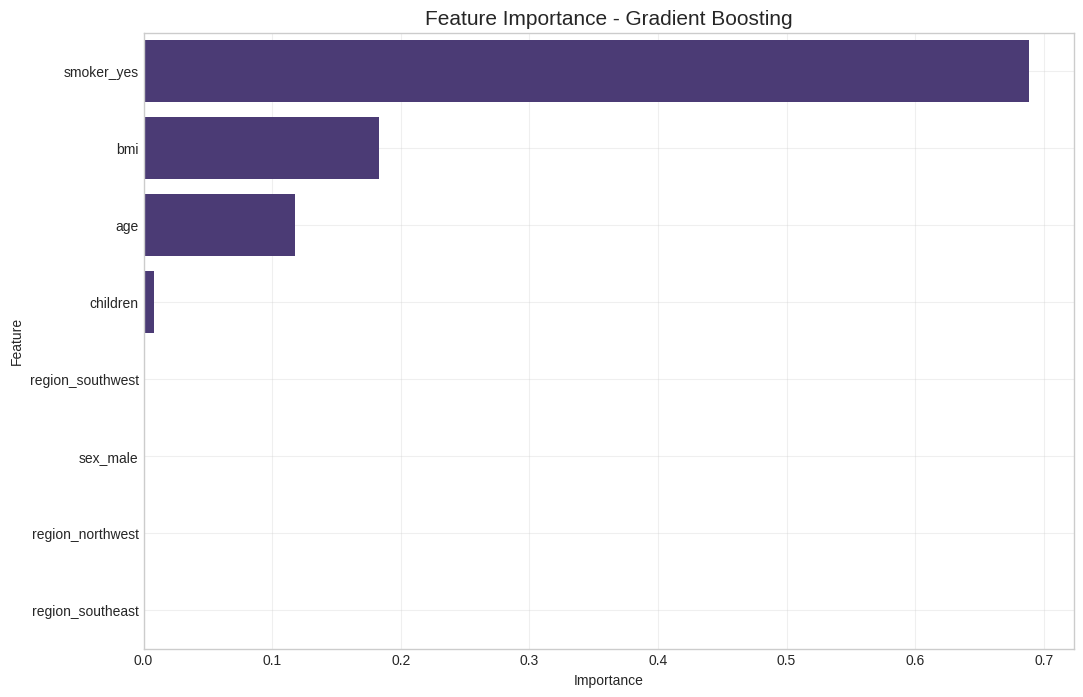

10 Fitur Terpenting:
            Feature  Importance
4        smoker_yes    0.688751
1               bmi    0.183303
0               age    0.117662
2          children    0.008138
7  region_southwest    0.001240
3          sex_male    0.000479
5  region_northwest    0.000362
6  region_southeast    0.000066


In [23]:
# Ekstrak model terbaik Gradient Boosting
best_model = gb_cv.best_estimator_
best_model_name = "Gradient Boosting"

# Dapatkan feature importances jika model adalah tree-based (Random Forest atau Gradient Boosting)
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    # Dapatkan nama fitur setelah preprocessing
    cat_features = best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
    feature_names = np.concatenate([numeric_features, cat_features])

    # Dapatkan feature importances
    importances = best_model.named_steps['regressor'].feature_importances_

    # Membuat DataFrame untuk visualisasi
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Visualisasi feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature Importance - {best_model_name}', fontsize=15)
    plt.grid(True, alpha=0.3)
    plt.show()

    print("10 Fitur Terpenting:")
    print(importance_df.head(10))

**Interpretasi Model**

In [24]:
# Untuk model linear (Linear Regression atau Ridge), kita bisa melihat koefisien
if best_model_name in ["Linear Regression", "Ridge Regression"]:
    # Dapatkan nama fitur setelah preprocessing
    cat_features = best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
    feature_names = np.concatenate([numeric_features, cat_features])

    # Dapatkan koefisien
    coefficients = best_model.named_steps['regressor'].coef_

    # Membuat DataFrame untuk visualisasi
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)

    # Visualisasi koefisien
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.title(f'Feature Coefficients - {best_model_name}', fontsize=15)
    plt.grid(True, alpha=0.3)
    plt.show()

    print("Koefisien Model:")
    print(coef_df)


**Evaluasi**

In [25]:
# Ambil model terbaik berdasarkan R²
best_model_idx = results_df['r2'].idxmax()
best_model_info = results_df.iloc[best_model_idx]
best_model_name = best_model_info['name']

print(f"\nModel Terbaik: {best_model_name}")
print(f"R² Score: {best_model_info['r2']:.4f}")
print(f"RMSE: ${best_model_info['rmse']:.2f}")
print(f"MAE: ${best_model_info['mae']:.2f}")


Model Terbaik: Gradient Boosting Regression
R² Score: 0.8791
RMSE: $4332.08
MAE: $2464.90


**Analisis Residual**

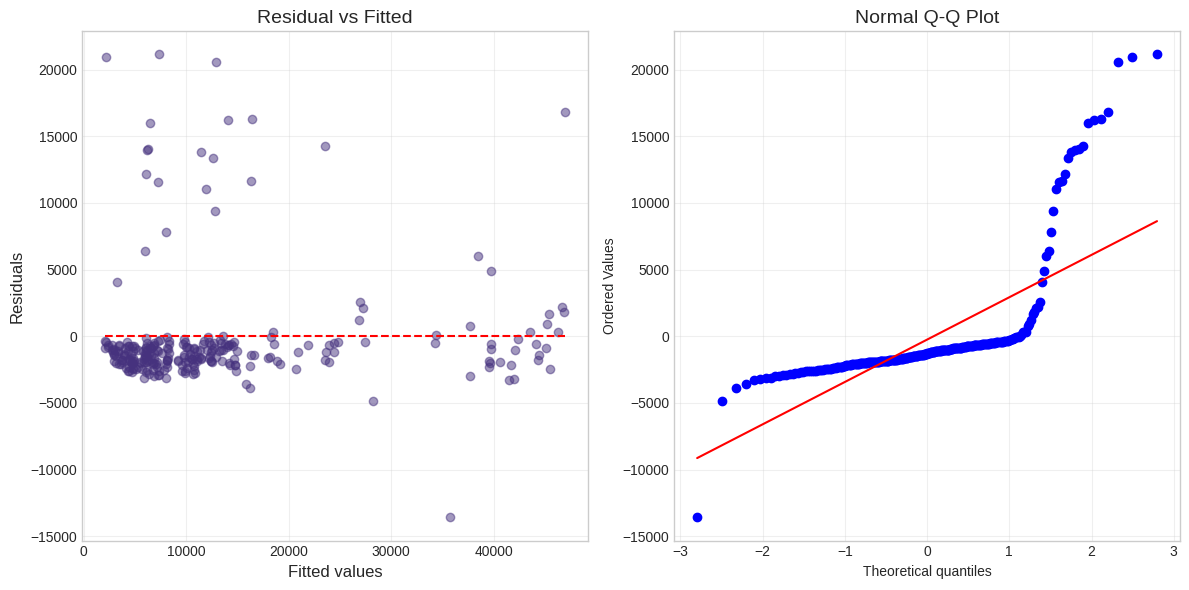

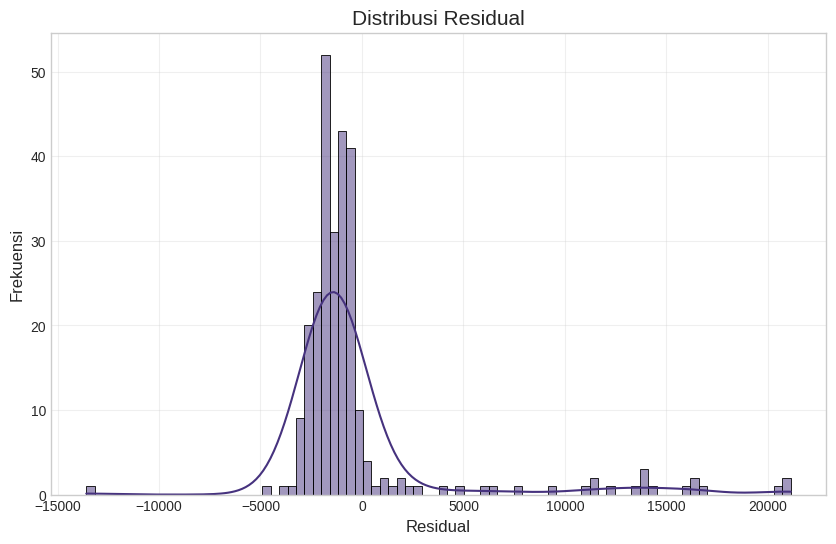


Statistik Residual:
Mean: -251.2290
Std Dev: 4332.8843
Min: -13583.7561
Max: 21127.0641


In [26]:
# Menggunakan model terbaik untuk prediksi
if best_model_name == "Linear Regression":
    best_model = lr_pipeline
elif best_model_name == "Ridge Regression":
    best_model = ridge_cv.best_estimator_
elif best_model_name == "Random Forest Regression":
    best_model = rf_cv.best_estimator_
else:  # Gradient Boosting
    best_model = gb_cv.best_estimator_

# Prediksi pada data test
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

# Plot residual
plt.figure(figsize=(12, 6))

# Residual vs Fitted
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.title('Residual vs Fitted', fontsize=14)
plt.xlabel('Fitted values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(True, alpha=0.3)

# QQ plot untuk normalitas residual
plt.subplot(1, 2, 2)
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribusi residual
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribusi Residual', fontsize=15)
plt.xlabel('Residual', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Statistik residual
print("\nStatistik Residual:")
print(f"Mean: {residuals.mean():.4f}")
print(f"Std Dev: {residuals.std():.4f}")
print(f"Min: {residuals.min():.4f}")
print(f"Max: {residuals.max():.4f}")

**Contoh Prediksi**

In [28]:
# Membuat fungsi untuk prediksi biaya asuransi
def predict_insurance_cost(age, sex, bmi, children, smoker, region):
    # Buat data sample baru
    sample = pd.DataFrame({
        'age': [age],
        'sex': [sex],
        'bmi': [bmi],
        'children': [children],
        'smoker': [smoker],
        'region': [region],
        'bmi_smoker': [bmi * (smoker == 'yes')],
        'age_smoker': [age * (smoker == 'yes')]
    })

    # Prediksi biaya menggunakan model terbaik
    predicted_cost = best_model.predict(sample)[0]

    return predicted_cost

# Contoh beberapa kasus untuk prediksi
test_cases = [
    {'age': 30, 'sex': 'male', 'bmi': 25.0, 'children': 0, 'smoker': 'no', 'region': 'southeast'},
    {'age': 30, 'sex': 'male', 'bmi': 25.0, 'children': 0, 'smoker': 'yes', 'region': 'southeast'},
    {'age': 50, 'sex': 'female', 'bmi': 30.0, 'children': 2, 'smoker': 'no', 'region': 'northeast'},
    {'age': 50, 'sex': 'female', 'bmi': 30.0, 'children': 2, 'smoker': 'yes', 'region': 'northeast'}
]

# Prediksi untuk masing-masing kasus
print("\nContoh Prediksi Biaya Asuransi:")
for i, case in enumerate(test_cases):
    cost = predict_insurance_cost(**case)
    print(f"\nKasus {i+1}:")
    for key, value in case.items():
        print(f"- {key}: {value}")
    print(f"Prediksi Biaya Asuransi: ${cost:.2f}")


Contoh Prediksi Biaya Asuransi:

Kasus 1:
- age: 30
- sex: male
- bmi: 25.0
- children: 0
- smoker: no
- region: southeast
Prediksi Biaya Asuransi: $4783.19

Kasus 2:
- age: 30
- sex: male
- bmi: 25.0
- children: 0
- smoker: yes
- region: southeast
Prediksi Biaya Asuransi: $18085.35

Kasus 3:
- age: 50
- sex: female
- bmi: 30.0
- children: 2
- smoker: no
- region: northeast
Prediksi Biaya Asuransi: $11697.73

Kasus 4:
- age: 50
- sex: female
- bmi: 30.0
- children: 2
- smoker: yes
- region: northeast
Prediksi Biaya Asuransi: $38238.38
